In [21]:
import mne
import numpy as np
from mne.time_frequency import tfr_morlet
import pandas as pd
import matplotlib.pyplot as plt

### Things modified :
     1) took out EEG for one subject as all redundant
     2) added a pre-stim of -200ms to 0ms  before onset 
     3) found some noise can be created by slow dirfts and high frequency noise so i took those out (i did coment that section out cause it was very long to process)
     4) Took out all code for 5, 9, 13, as we are taking those out of the hypothesis

# For loop for multiple patients

In [35]:
conj_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc'
]

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)

    # Step 1: Bandpass filter to remove slow drift and high-frequency noise
    #ep.filter(0.1, 40., fir_design='firwin')
    
    # Step 2: Set EEG reference (common average reference here)
    #ep.set_eeg_reference('average', projection=False)
    
    # Step 3: Baseline correction
    # This removes pre-stimulus drift for each trial and channel.
    # - Define baseline window: from -200ms to 0ms (before stimulus onset)
    ep.apply_baseline(baseline=(-0.2, 0))
    
    # Select only conjunction conditions
    existing = [cond for cond in conj_conditions if cond in ep.event_id]
    if not existing:
        continue

    condition_epochs = ep[existing]

    # Average evoked for chosen channels
    evoked = condition_epochs.average(picks=roi_channels)
    n1_chan, n1_lat, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
    p3b_chan, p3b_lat, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
   
    # Compute PSD using multitaper, only EEG channels
    picks = mne.pick_types(condition_epochs.info, eeg=True)
    psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
    psds, freqs = psd.get_data(return_freqs=True)

    # Average across epochs
    avg_psd = psds.mean(axis=0)

    # Get correct channel names for picked channels
    picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

    # Create PSD DataFrame
    psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

    # Band power calculation (on frontal ROI)
    band_powers = {}
    valid_roi_channels = list(set(roi_channels).intersection(set(psd_df.index)))
    for band_name, (fmin, fmax) in bands.items():
        if valid_roi_channels:
            band_power = psd_df.loc[valid_roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
        else:
            band_power = None
        band_powers[band_name] = band_power
        
    # Get subject and diagnosis (This needs to me changed as it is not 
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    # Append all measures to list
    all_measures.append({
        'subject': subject_id,
        'diagnosis': diagnosis,
        'N1_amp': n1_amp,
        'N1_lat': n1_chan,
        'N1_chan': n1_lat,
        'P3b_amp': p3_amp,
        'P3b_lat': p3_chan,
        'P3b_chan': p3_lat,
        'alpha_power': band_powers.get('alpha'),
        'gamma_power': band_powers.get('gamma')
    })

# Final DataFrame
results_df = pd.DataFrame(all_measures)
results_df

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows


,subject,diagnosis,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,-0.000008,E87,0.129,0.000018,0.308,E87,2.973600e-09,1.147995e-10
1,1109M1,control,-0.000004,E53,0.115,0.000002,0.308,E87,7.831558e-10,7.528146e-11


Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s finished


        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s finished


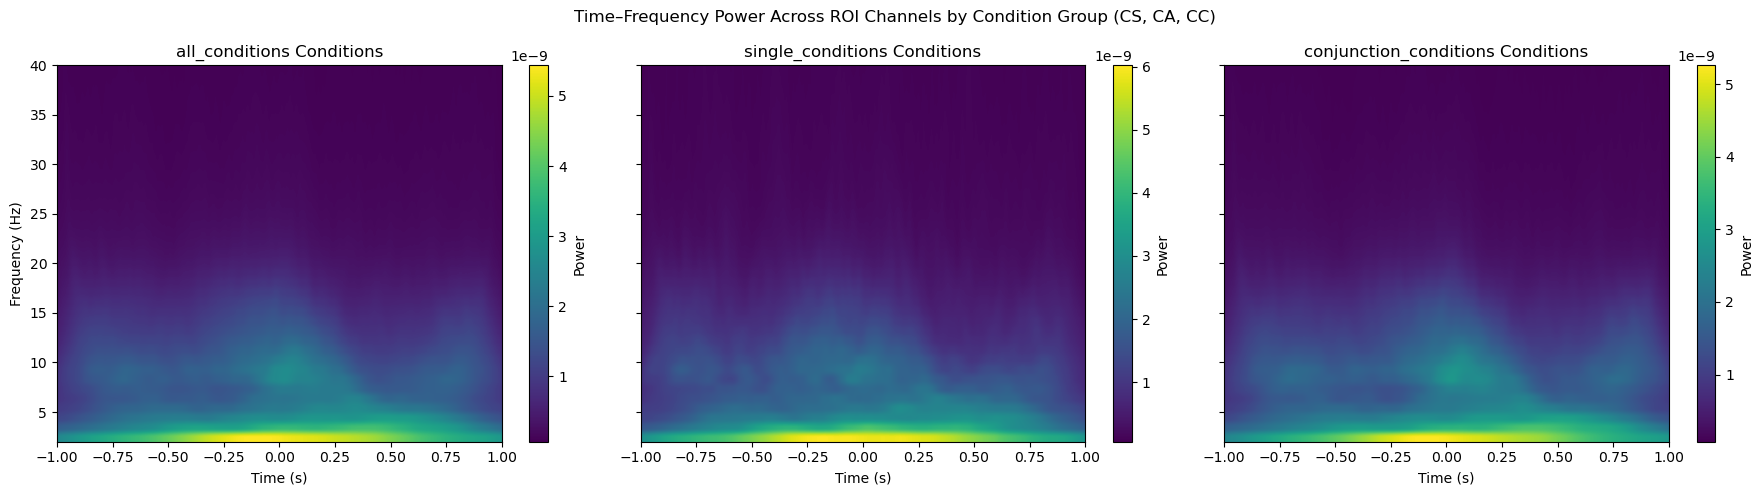

In [37]:
cs_conditions = [
    'vs/display/search/a5/cs',
    'vs/display/search/a9/cs',
    'vs/display/search/at/cs',
]

ca_conditions = [
    'vs/display/search/a5/ca',
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

cc_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc',
]

condition_sets = {
    'all_conditions': cs_conditions + ca_conditions + cc_conditions,
    'single_conditions': cs_conditions + ca_conditions,
    'conjunction_conditions': cc_conditions,
}

# --- EEG Files ---
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

# --- ROI Channels ---
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# --- Time-Frequency Parameters ---
freqs = np.arange(2, 41, 1)
n_cycles = 4

# --- Container for Averaged TFRs ---
group_tfr_data = {key: [] for key in condition_sets}

# --- Loop Over Files ---
for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    for group_label, cond_list in condition_sets.items():
        valid_conds = [cond for cond in cond_list if cond in ep.event_id]
        if not valid_conds:
            continue

        cond_epochs = ep[valid_conds].copy().pick_channels(roi_channels)

        # TFR using multitaper method
        tfr = mne.time_frequency.tfr_multitaper(
            cond_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            use_fft=True,
            return_itc=False,
            average=True
        )

        # Average across ROI channels (data shape: [n_channels, n_freqs, n_times])
        roi_mean = tfr.data.mean(axis=0)  # shape: (n_freqs, n_times)
        group_tfr_data[group_label].append(roi_mean)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
times = tfr.times

for i, group_label in enumerate([ 'all_conditions','single_conditions','conjunction_conditions']):
    data_list = group_tfr_data[group_label]
    if data_list:
        mean_power = np.mean(data_list, axis=0)  # shape: (freqs, times)

        im = axes[i].imshow(
            mean_power, aspect='auto', origin='lower',
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap='viridis'
        )

        axes[i].set_title(f"{group_label} Conditions")
        axes[i].set_xlabel('Time (s)')
        if i == 0:
            axes[i].set_ylabel('Frequency (Hz)')

        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Power')

plt.suptitle("Time–Frequency Power Across ROI Channels by Condition Group (CS, CA, CC)")
plt.tight_layout()
plt.show()

In [51]:
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]
all_measures = [] 
for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'


    for cond_set_name, cond_list in condition_sets.items():
        # Filter conditions that exist in this file
        existing_conds = [c for c in cond_list if c in ep.event_id]
        if not existing_conds:
            print(f"No {cond_set_name} found in {filepath}, skipping.")
            continue

        condition_epochs = ep[existing_conds]

        # Average evoked for ROI channels
        evoked = condition_epochs.average(picks=roi_channels)

        # Get N1 peak (~100ms, negative peak)
        n1_chan, n1_lat, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)

        # Get P3b peak (~300-500ms, positive peak)
        p3_chan, p3_lat, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

        # Compute PSD using multitaper, EEG channels only
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)

        # Average across epochs
        avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band power calculation on ROI channels
        band_powers = {}
        for band_name, (fmin, fmax) in bands.items():
            try:
                band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
            except KeyError:
                band_power = None
            band_powers[band_name] = band_power

        # Append results
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'condition_set': cond_set_name,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3_amp,
            'P3b_lat': p3_lat,
            'P3b_chan': p3_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma'),
        })

results_df = pd.DataFrame(all_measures)
results_df

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
 

,subject,diagnosis,condition_set,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,all_conditions,-0.000005,0.135,E87,0.000013,0.381,E59,2.899331e-09,1.159023e-10
1,1109P,asd,single_conditions,-0.000009,0.080,E59,0.000015,0.381,E59,2.687133e-09,1.190531e-10
2,1109P,asd,conjunction_conditions,-0.000006,0.129,E87,0.000011,0.381,E59,2.973600e-09,1.147995e-10
3,1109M1,control,all_conditions,-0.000004,0.116,E53,0.000003,0.433,E59,7.252936e-10,7.473628e-11
4,1109M1,control,single_conditions,-0.000006,0.116,E53,0.000004,0.433,E59,5.599728e-10,7.317863e-11
5,1109M1,control,conjunction_conditions,-0.000004,0.098,E87,0.000003,0.428,E59,7.831558e-10,7.528146e-11


Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


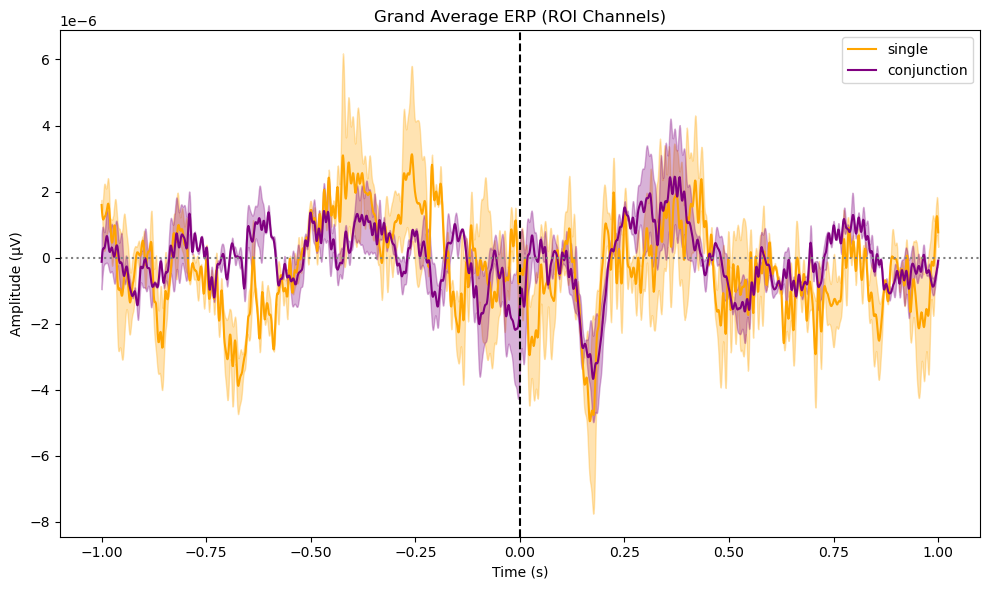

In [30]:
# Re-load epochs just for ERP waveform averaging
erp_by_detail = {'single': [], 'conjunction': []}
detail_conditions = {
    'single': ['vs/display/search/a5/cs', 'vs/display/search/a9/cs', 'vs/display/search/at/cs',
               'vs/display/search/a5/ca', 'vs/display/search/a9/ca', 'vs/display/search/at/ca'],
    'conjunction': ['vs/display/search/a5/cc', 'vs/display/search/a9/cc', 'vs/display/search/at/cc']
}

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)

    for detail, conds in detail_conditions.items():
        existing = [c for c in conds if c in ep.event_id]
        if not existing:
            continue
        epochs = ep[existing].copy().pick_channels(roi_channels)
        # Average across ROI channels and then across epochs
        erp_data = epochs.get_data().mean(axis=1).mean(axis=0)  # shape: (n_times,)
        erp_by_detail[detail].append(erp_data)

# Now average across participants
times = ep.times
plt.figure(figsize=(10, 6))
colors = {'single': 'orange', 'conjunction': 'purple'}

for detail in erp_by_detail:
    data = np.vstack(erp_by_detail[detail])  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    plt.plot(times, mean, label=detail, color=colors[detail])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[detail], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Grand Average ERP (ROI Channels)")
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
condition_sets = {
    'single_conditions': cs_conditions + ca_conditions,
    
    'conjunction_conditions': cc_conditions,
}
from collections import defaultdict

# To store trial counts per file
trial_counts = []

for filepath in epoch_files:
    print(f"\n🔍 Checking file: {filepath}")
    ep = mne.read_epochs(filepath, preload=False)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]

    subject_counts = {'subject': subject_id}

    for cond_set_name, cond_list in {
        'Single': condition_sets['single_conditions'],
        'Conjunction': condition_sets['conjunction_conditions']
    }.items():
        existing_conds = [c for c in cond_list if c in ep.event_id]

        if not existing_conds:
            subject_counts[cond_set_name] = 0
            continue

        # Count epochs for these conditions
        n_epochs = sum(len(ep[c]) for c in existing_conds)
        subject_counts[cond_set_name] = n_epochs
        print(f"{cond_set_name} trials: {n_epochs}")

    trial_counts.append(subject_counts)

# Create a summary DataFrame
counts_df = pd.DataFrame(trial_counts)
print("Trial counts per subject:")
print(counts_df)


🔍 Checking file: /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Single trials: 7
Conjunction trials: 20

🔍 Checking file: /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Single trials: 7
Conjunction trials: 20
Trial counts per subject:
  subject  Single  Conjunction
0   1109P       7           20
1 

In [56]:
# Define again for safety
cs_conditions = [
    'vs/display/search/a5/cs',
    'vs/display/search/a9/cs',
    'vs/display/search/at/cs',
]

ca_conditions = [
    'vs/display/search/a5/ca',
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

# Store results
trial_counts = []

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=False)
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]

    # Initialize counts
    subject_result = {'subject': subject_id}

    for label, cond_list in {'CS': cs_conditions, 'CA': ca_conditions}.items():
        existing_conds = [c for c in cond_list if c in ep.event_id]
        n_trials = sum(len(ep[c]) for c in existing_conds) if existing_conds else 0
        subject_result[label] = n_trials


    trial_counts.append(subject_result)

# Final table
counts_df = pd.DataFrame(trial_counts)

counts_df

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated


,subject,CS,CA
0,1109P,3,4
1,1109M1,4,3


In [ ]:
#create a map of events 

# Plot ERPs for different condition sizes

In [ ]:
# Plotting
times = ep.times
plt.figure(figsize=(10, 6))

colors = {
    'vs/display/search/a5/cc': 'blue',
    'vs/display/search/a9/cc': 'black',
    'vs/display/search/at/cc': 'red'
}

for cond, waveforms in condition_erps.items():
    data = np.array(waveforms)  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    
    plt.plot(times, mean, label=cond.split('/')[-2], color=colors[cond])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[cond], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("ERP at ROI Channels (P3/P4/P7/P8) per Condition")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

# Plot ERPs for single vs conjuction size

In [ ]:
times = ep.times
plt.figure(figsize=(10, 6))
colors = {'single': 'orange', 'conjunction': 'purple'}

for detail in erp_by_detail:
    data = np.vstack(erp_by_detail[detail])  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    plt.plot(times, mean, label=detail, color=colors[detail])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[detail], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Grand Average ERP (ROI Channels)")
plt.legend()
plt.tight_layout()
plt.show()

## Post revisions version

### Select conditions

In [ ]:
# Define experimental conditions
single_search_conditions = [  # Combined color search + slice search
    'vs/display/search/a5/cs',  # Color search
    'vs/display/search/a9/cs', 
    'vs/display/search/at/cs',
    'vs/display/search/a5/ca',  # Slice search  
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

conjunction_search_conditions = [  # Conjunction search (both types)
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc',
]

# Group conditions for analysis
condition_groups = {
    'single_search': single_search_conditions,
    'conjunction_search': conjunction_search_conditions,
    'all_conditions': single_search_conditions + conjunction_search_conditions
}

# Analysis parameters
baseline_window = (-0.2, 0)  # 200ms pre-stimulus baseline
n1_window = (0.08, 0.14)     # N1 component window
p3_window = (0.3, 0.5)       # P3 component window
min_trials = 10              # Minimum trials per condition

# ROI channels
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 
         'gamma': (30, 45)}

#file_pattern = '/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/*epo.fif'

# To run locally
#file_pattern= '/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif'


## Get files

In [ ]:

epoch_files = glob.glob(file_pattern)
print(f"Found {len(epoch_files)} files to process")
#Select where to save the data
# Main results storage
all_results = []           # ERP components and spectral power
all_erp_data = []         # ERP waveforms for plotting
quality_issues = defaultdict(list)  # Track data quality problems

# Time-frequency analysis storage
all_tfr_data = []         # Time-frequency representations

In [ ]:
#Helper functions
def extract_subject_info(filepath):
    filename = filepath.split('/')[-1]
    subject_id = filename.split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'
    return subject_id, diagnosis

def compute_spectral_power_mne(epochs, roi_channels, freq_bands):
    """Compute spectral power using MNE functions"""
    # Pick ROI channels
    roi_epochs = epochs.copy().pick_channels(roi_channels)
    
    # Compute PSD using MNE
    psd = roi_epochs.compute_psd(method='welch', fmin=1, fmax=50, verbose=False)
    psds, freqs = psd.get_data(return_freqs=True)
    
    # Average across trials and channels
    avg_psd = psds.mean(axis=(0, 1))  # Shape: (n_freqs,)
    
    # Calculate band power
    band_powers = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        if np.any(freq_mask):
            band_power = avg_psd[freq_mask].mean()
            band_powers[f'{band_name}_power'] = band_power
        else:
            band_powers[f'{band_name}_power'] = np.nan
    
    return band_powers

In [ ]:
# Extract data
for i, filepath in enumerate(tqdm(epoch_files, desc="Processing files")):
    print(f"Processing file {i+1}/{len(epoch_files)}: {filepath.split('/')[-1]}")
    
    try:
        # Load epochs
        epochs = mne.read_epochs(filepath, preload=True, verbose=False)
        
        # Get subject info
        subject_id, diagnosis = extract_subject_info(filepath)
        
        
        # Apply baseline correction  
        epochs = epochs.apply_baseline(baseline_window)
        
        # Process each condition group
        for group_name, conditions in condition_groups.items():
            if group_name == 'all_conditions':
                continue
                
            # Find conditions that exist in this dataset
            existing_conditions = [c for c in conditions if c in epochs.event_id]
            
            if not existing_conditions:
                quality_issues[subject_id].append(f"No {group_name} conditions found")
                continue
            
            # Select epochs for this condition group
            condition_epochs = epochs[existing_conditions]
            n_trials = len(condition_epochs)
            
            # Quality control: check minimum trials
            if n_trials < min_trials:
                quality_issues[subject_id].append(f"Low trial count {group_name}: {n_trials}")
                print(f"  Warning: Only {n_trials} trials for {group_name}")
            
            # Select ROI channels and compute evoked response using MNE
            roi_epochs = condition_epochs.copy().pick_channels(roi_channels)
            evoked = roi_epochs.average()
            
            # ERP COMPONENT EXTRACTION USING MNE
            
            # N1 component (negative peak, 80-140ms)
            try:
                n1_channel, n1_lat, n1_amp = evoked.get_peak(
                    tmin=n1_window[0], tmax=n1_window[1], 
                    mode='neg', return_amplitude=True
                )
            except ValueError:
                n1_channel, n1_lat, n1_amp= np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"N1 not found: {group_name}")
            
            # P3 component (positive peak, 300-500ms) 
            try:
               p3_channel, p3_lat, p3_amp = evoked.get_peak(
                    tmin=p3_window[0], tmax=p3_window[1],
                    mode='pos', return_amplitude=True
                )
            except ValueError:
                p3_channel, p3_lat, p3_amp = np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"P3 not found: {group_name}")
            
            # SPECTRAL POWER ANALYSIS USING MNE
            
            band_powers = compute_spectral_power_mne(condition_epochs, roi_channels, bands)
            
            # STORE RESULTS
            
            # Store ERP waveform data for plotting
            erp_waveform = {
                'subject': subject_id,
                'diagnosis': diagnosis, 
                'condition_group': group_name,
                'n_trials': n_trials,
                'times': evoked.times,
                'amplitude': evoked.data.mean(axis=0),  # Average across ROI channels
                'roi_channels': ','.join(roi_channels)
            }
            all_erp_data.append(erp_waveform)
            
            # Store summary results
            result = {
                'subject': subject_id,
                'diagnosis': diagnosis,
                'condition_group': group_name, 
                'n_trials': n_trials,
                'roi_channels': ','.join(roi_channels),
                'N1_channel': n1_channel,
                'N1_amplitude': n1_amp,
                'N1_latency': n1_lat,
                'P3_channel': p3_channel,
                'P3_amplitude': p3_amp,
                'P3_latency': p3_lat,
                **band_powers
            }
            all_results.append(result)
    
    except Exception as e:
        print(f"  Error processing {filepath}: {e}")
        subject_id, _ = extract_subject_info(filepath)
        quality_issues[subject_id].append(f"Processing failed: {e}")

print("Main processing completed!")

In [ ]:
# Create dataframe with ERP info
# Convert results to DataFrames
results_df = pd.DataFrame(all_results)
print(f"\nProcessed {results_df['subject'].nunique()} subjects")

# Create ERP waveform DataFrame for plotting
erp_data_list = []
for erp_dict in all_erp_data:
    n_timepoints = len(erp_dict['times'])
    erp_df = pd.DataFrame({
        'time': erp_dict['times'],
        'amplitude': erp_dict['amplitude'],
        'subject': [erp_dict['subject']] * n_timepoints,
        'diagnosis': [erp_dict['diagnosis']] * n_timepoints,
        'condition_group': [erp_dict['condition_group']] * n_timepoints,
        'n_trials': [erp_dict['n_trials']] * n_timepoints
    })
    erp_data_list.append(erp_df)

if erp_data_list:
    erp_df = pd.concat(erp_data_list, ignore_index=True)
    print(f"ERP waveform data: {len(erp_df)} timepoints")
else:
    erp_df = pd.DataFrame()
    print("No ERP waveform data available")

In [ ]:
results_df

In [ ]:
# Check number of issues with processes data
if quality_issues:
    for subject, issues in quality_issues.items():
        print(f"\nSubject {subject}:")
        for issue in issues:
            print(f"  - {issue}")
else:
    print("No quality issues detected!")

# Summary statistics
print(f"\nSUMMARY:")
print(f"- Total subjects processed: {results_df['subject'].nunique()}")
print(f"- Subjects with issues: {len(quality_issues)}")
print(f"- Average trials per condition: {results_df['n_trials'].mean():.1f}")
print(f"- Minimum trials: {results_df['n_trials'].min()}")

In [ ]:
#Plot ERP differences between conditions
if not erp_df.empty:
    
    # Create evoked objects for each condition
    evoked_dict = {}
    
    for condition in ['single_search', 'conjunction_search']:
        condition_data = erp_df[erp_df['condition_group'] == condition]
        
        if not condition_data.empty:
            # Compute grand average
            grand_avg = condition_data.groupby('time')['amplitude'].mean()
            times = grand_avg.index.values
            data = grand_avg.values.reshape(1, -1)  # Shape: (1 channel, n_times)
            
            # Create minimal info structure
            info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])
            
            # Create evoked object
            evoked = mne.EvokedArray(data, info, tmin=times[0])
            evoked_dict[condition.replace('_', ' ').title()] = evoked
    
    if len(evoked_dict) == 2:
        # Plot comparison using MNE
        fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='Single vs Conjunction Search - ERP Comparison',
                                   colors=['orange', 'purple'], ci=True, show='separate', show_sensors='upper right')
        plt.show()

In [ ]:
#Plot differences between ASD and Controls in conjuction
# Plot group differences
if not erp_df.empty:
    
    # Create evoked objects for each condition
    evoked_dict = {}
    
    for diagnosis in results_df['diagnosis'].unique():
        condition_data = erp_df[erp_df['diagnosis'] == diagnosis]
        
        # Select only conjunction conditions
        condition_data = condition_data[condition_data['condition_group'] == 'conjunction_search']
        
        if not condition_data.empty:
            # Compute grand average
            grand_avg = condition_data.groupby('time')['amplitude'].mean()
            times = grand_avg.index.values
            data = grand_avg.values.reshape(1, -1)
            # Create minimal info structure
            info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])  
            
            # Create evoked object
            evoked = mne.EvokedArray(data, info, tmin=times[0])
            evoked_dict[diagnosis] = evoked
    if len(evoked_dict) == 2:
        # Plot comparison using MNE
        fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='ASD vs Control - ERP Comparison',
                                   colors=['blue', 'red'], ci=True, show='separate', show_sensors='upper right')
        plt.show()

In [ ]:
#Spectral power comparison
if not results_df.empty:
    # Alpha vs Gamma power comparison between conditions
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Alpha power
    ax1 = axes[0]
    valid_alpha = results_df.dropna(subset=['alpha_power'])
    if not valid_alpha.empty:
        sns.boxplot(data=valid_alpha, x='condition_group', y='alpha_power', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('Alpha Power (8-13 Hz)\nSingle vs Conjunction Search')
        ax1.set_ylabel('Alpha Power (μV²)')
        ax1.set_xlabel('Search Type')

    # Gamma power
    ax2 = axes[1]
    valid_gamma = results_df.dropna(subset=['gamma_power'])
    if not valid_gamma.empty:
        sns.boxplot(data=valid_gamma, x='condition_group', y='gamma_power', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('Gamma Power (30-45 Hz)\nSingle vs Conjunction Search')
        ax2.set_ylabel('Gamma Power (μV²)')
        ax2.set_xlabel('Search Type')
        

    plt.tight_layout()
    plt.show()

In [ ]:
#Amplitude differences
# Plot differences in N1 and P3 amplitudes
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 amplitude
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_amplitude'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='condition_group', y='N1_amplitude', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Amplitude\nSingle vs Conjunction Search')
        ax1.set_ylabel('N1 Amplitude (μV)')
        ax1.set_xlabel('Search Type')

    # P3 amplitude
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3_amplitude'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='condition_group', y='P3_amplitude', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Amplitude\nSingle vs Conjunction Search')
        ax2.set_ylabel('P3 Amplitude (μV)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()

In [ ]:
#Latency differences

# Plotting differences in N1 and P3 latencies   
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 latency
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_latency'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='condition_group', y='N1_latency', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Latency\nSingle vs Conjunction Search')
        ax1.set_ylabel('N1 Latency (s)')
        ax1.set_xlabel('Search Type')

    # P3 latency
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3_latency'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='condition_group', y='P3_latency', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Latency\nSingle vs Conjunction Search')
        ax2.set_ylabel('P3 Latency (s)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()